In [14]:
import numpy as np

import torch
import torch.utils.data
import cv2
from tqdm import tqdm

import datasets
import metaimage
import nnet
import voxel
import display

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Dataset generation

The dataset used for this prototype is a synthetic dataset consisting of masks of a range of ellipsoids of varying radius and length, created from randomised angles. This is intended to test if variations in the shape can be recreated from the masks.

As generation of the ellipsoids is a little slow, it is done once and saved for loading later. Setting GEN to True will regenerate the dataset, False will load the dataset from the file.

In [24]:
GEN = False

N_IMGS = 5000
N_TRAIN = int(N_IMGS * 0.9)

R_RANGE = (6, 9)
LENGTH_RANGE = (1, 2)
SPACE_SIZE = (32, 32, 32)

if GEN:
    for i in tqdm(range(N_IMGS)):
        length_multi = np.random.uniform(*LENGTH_RANGE)
        r = np.random.uniform(*R_RANGE)

        ellipsoid = voxel.create.spheroid(length_multi, r, SPACE_SIZE)

        angles = np.random.uniform(0, 2 * np.pi, size=3)

        mask = ellipsoid.create_mask(*angles)

        cv2.imwrite(f"images/ellipsoid/{i}.png", mask.as_array())
        np.save(f"voxels/ellipsoid/{i}.npy", ellipsoid.as_array())

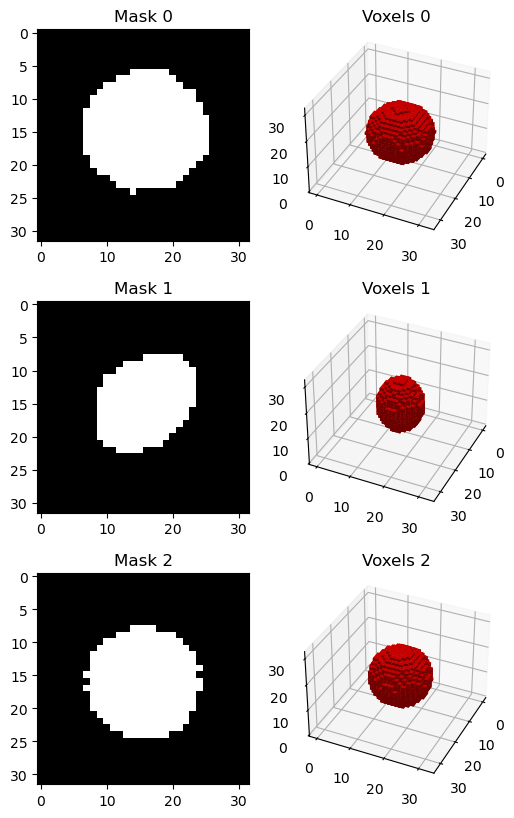

In [25]:
IMAGE_SIZE = (32, 32)

BATCH_SIZE = 100

IMG_FOLDER = "images/ellipsoid"
VOXEL_FOLDER = "voxels/ellipsoid"

train_auto_dataset = datasets.AutoImgCached(IMG_FOLDER, VOXEL_FOLDER, (0, N_TRAIN))
val_auto_dataset = datasets.AutoImgCached(IMG_FOLDER, VOXEL_FOLDER, (N_TRAIN, N_IMGS))

train_auto_loader = torch.utils.data.DataLoader(
    train_auto_dataset, batch_size=BATCH_SIZE, shuffle=True
)
val_auto_loader = torch.utils.data.DataLoader(val_auto_dataset, batch_size=BATCH_SIZE)

display.grid(
    [
        [
            (f"Mask {i}", train_auto_dataset[i][0]),
            (f"Voxels {i}", train_auto_dataset[i][1][1]),
        ]
        for i in range(3)
    ],
    figsize=(6, 10),
)
display.show()

## GAN

To recover the shape, a GAN is used.

### Generator

The generator is a 3D convolutional network. The latent space is mapped linearly to a 32x4x4x4 tensor. This is then repeatedly upsampled using convolutional layer followed by a strided transpose convolution. This doubles the dimensions and halves the number of channels at each stage, to reach a 4x32x32x32 tensor. Finally, this is passed through a resnet block for refinement, and a final convolutional layer to produce a 1x32x32x32 tensor.

This tensor can then be returned, to provide a voxel representation, or a mask is created from a random angle around the cube to produce a 32x32 mask.

### Discriminator

The discriminator is a 2D resnet. This takes in a 32x32 mask, passes it through a resnet block and downsample using a strided convolution, halving the dimensions and doubling the number of channels at each stage. This is until a 4x4 mask is produced, which is then flattened and passed through a linear layer to produce a single label indicating the probability that the mask is real.

In [26]:
LATENT_SIZE = 12
BASE_CHANNELS = 8
DISCRIMINATOR_CHANNELS = 4
ACTIVATION = torch.nn.LeakyReLU

DISCRIMINATOR_DROPOUT = 0.2
GENERATOR_DROPOUT = 0.1

discriminator = torch.nn.Sequential(
    nnet.blocks.conv.BasicConvBlock(
        in_channels=1,
        out_channels=DISCRIMINATOR_CHANNELS,
        kernel_size=1,
        activation=ACTIVATION,
    ),
    nnet.blocks.conv.ResizeStack(
        in_shape=(DISCRIMINATOR_CHANNELS, IMAGE_SIZE[0], IMAGE_SIZE[1]),
        out_shape=(DISCRIMINATOR_CHANNELS * IMAGE_SIZE[0] // 2, 2, 2),
        layer_factory=nnet.blocks.resnet.create_resnet_2d_factory(
            stochastic_depth_rate=DISCRIMINATOR_DROPOUT,
            activation=ACTIVATION,
            dropout=DISCRIMINATOR_DROPOUT,
        ),
        resize_factory=nnet.blocks.conv.create_strided_downsample_factory(
            activation=ACTIVATION,
            dropout=DISCRIMINATOR_DROPOUT,
        ),
        layer_factories_per_downsample=0,
    ),
    nnet.blocks.conv.ConvToLinear(
        (DISCRIMINATOR_CHANNELS * IMAGE_SIZE[0] // 2, 2, 2),
        out_dim=1,
        activation=torch.nn.Sigmoid,
    ),
)

generator = nnet.generators.SolidMaskGenerator(
    torch.nn.Sequential(
        nnet.blocks.conv.LinearToConv(
            in_dim=LATENT_SIZE,
            out_shape=(BASE_CHANNELS * (SPACE_SIZE[0] // 2), 2, 2, 2),
            activation=ACTIVATION,
        ),
        nnet.blocks.conv.ResizeStack(
            in_shape=(BASE_CHANNELS * (SPACE_SIZE[0] // 2), 2, 2, 2),
            out_shape=(BASE_CHANNELS, SPACE_SIZE[0], SPACE_SIZE[1], SPACE_SIZE[2]),
            layer_factory=nnet.blocks.conv.create_basic_conv_factory(
                use_3d=True,
                dropout=GENERATOR_DROPOUT,
            ),
            resize_factory=nnet.blocks.conv.create_upsample_block_factory(
                use_3d=True,
                activation=ACTIVATION,
                dropout=GENERATOR_DROPOUT,
            ),
            layer_factories_per_downsample=0,
        ),
        nnet.blocks.resnet.create_resnet_block_simple_3d(
            in_channels=BASE_CHANNELS,
            out_channels=BASE_CHANNELS,
            activation=ACTIVATION,
            stochastic_depth_rate=GENERATOR_DROPOUT,
            kernel_size=3,
        ),
        nnet.blocks.conv.BasicConvBlock(
            use_3d=True,
            in_channels=BASE_CHANNELS,
            out_channels=1,
            activation=torch.nn.Sigmoid,
            kernel_size=1,
            use_batch_norm=False,
        ),
    ),
)

gan_trainer = nnet.training.GANTrainer(
    generator,
    discriminator,
    means=np.zeros(LATENT_SIZE),
    stds=np.ones(LATENT_SIZE),
    lr_gen=1e-3,
    lr_disc=1e-4,
)

In [34]:
MODEL_PATH = "models/ellip_gan"

gan_trainer.train(
    train_auto_loader,
    val_auto_loader,
    31,
    path=MODEL_PATH,
    noise=0.3,
    gen_train_thresh=1.25,
    dis_train_thresh=1.25,
)

Epoch 81/81 | val loss (gen/dis): 1.9485/2.0391 | train loss: 1.31(28)/0.94(20): 100%|██████████| 31/31 [13:30<00:00, 26.13s/it]


Model models/ellip_gan_5.pt is loaded from epoch 50 , loss 0.7837
Model models/ellip_gan_6.pt is loaded from epoch 60 , loss 1.3679
Model models/ellip_gan_7.pt is loaded from epoch 70 , loss 1.8026
Model models/ellip_gan_8.pt is loaded from epoch 80 , loss 1.9485


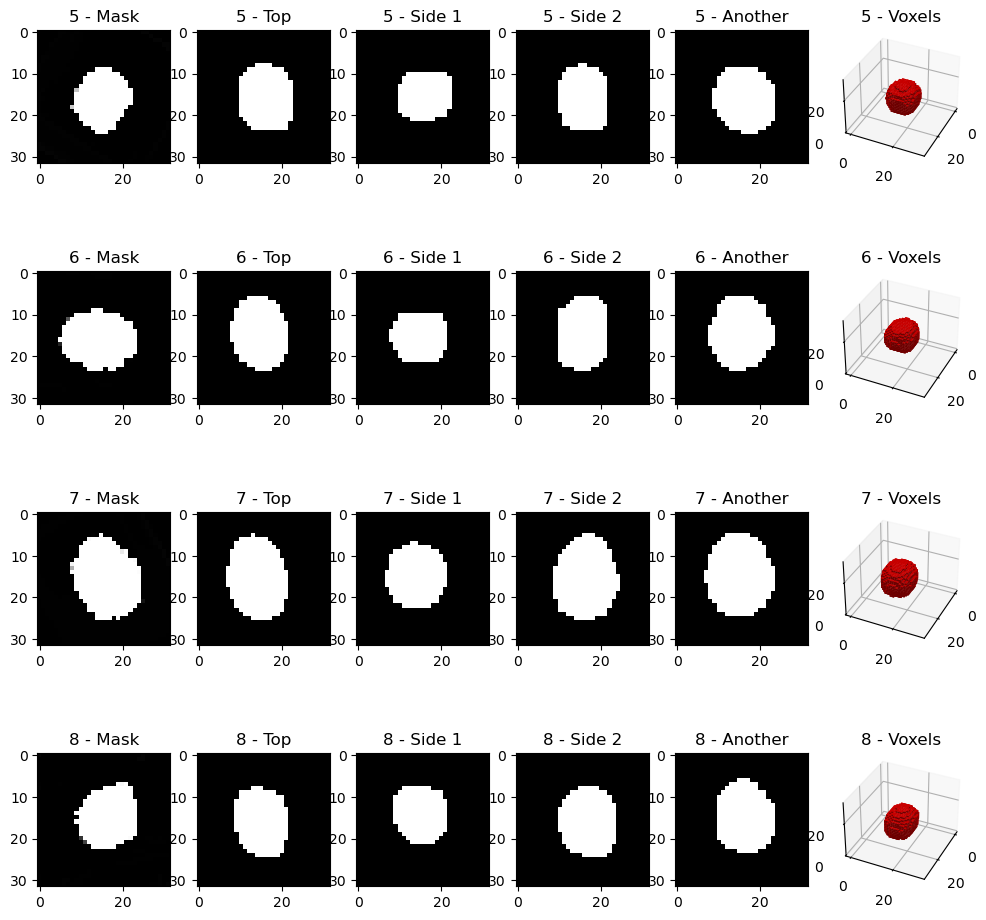

In [35]:
MODELS = (5, 8)

generator.eval()
generator.to("cuda")

N_MODELS = MODELS[1] - MODELS[0] + 1

gen_input = torch.Tensor(np.random.normal(0, 1, size=(2, LATENT_SIZE))).cuda()

plot_grid = []

for i in range(N_MODELS):
    model_n = MODELS[0] + i
    gan_trainer.load_state(f"{MODEL_PATH}_{model_n}.pt")

    mask = metaimage.Mask.from_tensor(
        generator(gen_input)[0], title=f"{model_n} - Mask"
    )
    voxels = voxel.SolidVoxel.from_tensor(
        generator.voxel_generator(gen_input)[0], title=f"{model_n} - Voxels"
    )

    plot_grid.append(
        [
            mask,
            (f"{model_n} - Top", voxels.create_mask()),
            (f"{model_n} - Side 1", voxels.create_mask(y_angle=np.pi / 2)),
            (f"{model_n} - Side 2", voxels.create_mask(x_angle=np.pi / 2)),
            (f"{model_n} - Another", voxels.create_mask(np.pi / 4, np.pi / 4)),
            voxels,
        ]
    )

display.grid(plot_grid, figsize=(12, 3 * N_MODELS))
display.show()

Model models/ellip_gan_7.pt is loaded from epoch 70 , loss 1.8026


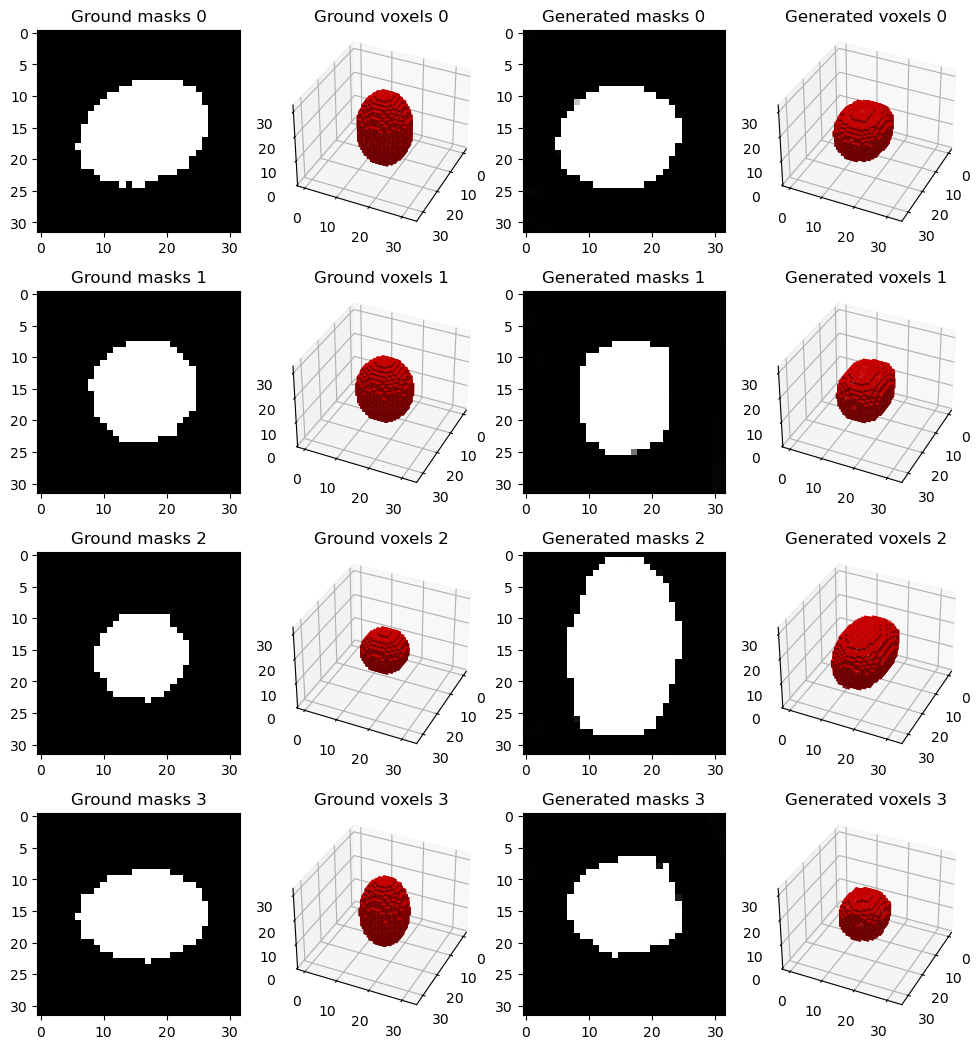

In [38]:
MODEL = 7

gan_trainer.load_state(f"{MODEL_PATH}_{MODEL}.pt")

gen_input = torch.Tensor(np.random.normal(0, 1, size=(4, LATENT_SIZE))).cuda()

masks = generator(gen_input)[:4]
voxels = generator.voxel_generator(gen_input)[:4]

plot_grid = []

for i in range(4):
    cur_voxels = voxel.TranspVoxel.from_tensor(voxels[i], title=f"Generated voxels {i}")
    cur_mask = metaimage.Mask.from_tensor(masks[i], title=f"Generated masks {i}")
    ground_mask, ground_voxels = val_auto_dataset[i][1]
    ground_mask = metaimage.Mask.from_tensor(ground_mask, title=f"Ground masks {i}")
    ground_voxels = voxel.TranspVoxel.from_array(
        ground_voxels, title=f"Ground voxels {i}"
    )

    plot_grid.append([ground_mask, ground_voxels, cur_mask, cur_voxels])

display.grid(plot_grid, figsize=(12, 13))
display.show()